# Please also refer to the accompanying *n-body-** notebooks Python files for the specific parallel solutions.  

In [4]:
import numpy as np

def remove_i(x, i):
    """Drops the ith element of an array."""
    shape = (x.shape[0]-1,) + x.shape[1:]
    y = np.empty(shape, dtype=float)
    y[:i] = x[:i]
    y[i:] = x[i+1:]
    return y

def a(i, x, G, m):
    """The acceleration of the ith mass."""
    x_i = x[i]
    x_j = remove_i(x, i)
    m_j = remove_i(m, i)
    diff = x_j - x_i
    mag3 = np.sum(diff**2, axis=1)**1.5
    result = G * np.sum(diff * (m_j / mag3)[:,np.newaxis], axis=0)
    return result

def timestep(x0, v0, G, m, dt):
    """Computes the next position and velocity for all masses given 
    initial conditions and a time step size.
    """
    N = len(x0)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i in range(N):
        a_i0 = a(i, x0, G, m)
        v1[i] = a_i0 * dt + v0[i]
        x1[i] = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return x1, v1

def initial_cond(N, D):
    """Generates initial conditions for N unity masses at rest 
    starting at random positions in D-dimensional space.
    """
    x0 = np.random.rand(N, D)
    v0 = np.zeros((N, D), dtype=float)
    m = np.ones(N, dtype=float)
    return x0, v0, m 

In [5]:
x0, v0, m = initial_cond(10, 2)
x1, v1 = timestep(x0, v0, 1.0, m, 1.0e-3)

In [6]:
def simulate(N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    for s in range(S):
        x1, v1 = timestep(x0, v0, G, m, dt)
        x0, v0 = x1, v1

In [12]:
import time
# Ns = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
Ns = [2, 4, 8, 16, 32,64,128,256,512,1024]
runtimes = []
for N in Ns:
    start = time.time()
    simulate(N, 2, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)
runtimes

[0.015008687973022461,
 0.02507328987121582,
 0.0499880313873291,
 0.10300207138061523,
 0.21500730514526367,
 0.4679555892944336,
 1.1159768104553223,
 2.7408454418182373,
 8.853973388671875,
 25.784214973449707]

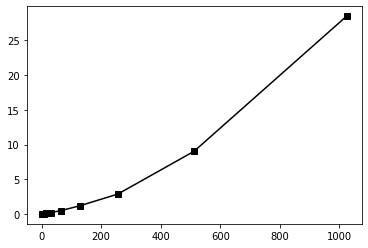

In [11]:
## visualize runtime
import matplotlib.pyplot as plt
plt.plot(Ns,runtimes,'ks-')

In [13]:
from threading import Thread

class Worker(Thread):
    """Computes x, v, and a of the ith body."""
    def __init__(self, *args, **kwargs):
        super(Worker, self).__init__(*args, **kwargs)
        self.inputs = []
        self.results = []
        self.running = True
        self.daemon = True
        self.start()
        
    def run(self):
        while self.running:
            if len(self.inputs) == 0:
                continue
            i, x0, v0, G, m, dt = self.inputs.pop(0)
            a_i0 = a(i, x0, G, m)
            v_i1 = a_i0 * dt + v0[i]
            x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
            result = (i, x_i1, v_i1)
            self.results.append(result)

In [14]:
class Pool(object):
    """A collection of P worker threads that distributes tasks 
    evenly across them.
    """
    def __init__(self, size):
        self.size = size
        self.workers = [Worker() for p in range(size)]
        
    def do(self, tasks):
        for p in range(self.size):
            self.workers[p].inputs += tasks[p::self.size]
        while any([len(worker.inputs) != 0 for worker in self.workers]):
            pass
        results = []
        for worker in self.workers:
            results += worker.results
            worker.results.clear()
        return results
    
    def __del__(self):
        for worker in self.workers:
            worker.running = False

In [15]:
def timestep(x0, v0, G, m, dt, pool):
    """Computes the next position and velocity for all masses given 
    initial conditions and a time step size.
    """
    N = len(x0)
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)]
    results = pool.do(tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

In [16]:
def simulate(P, N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    pool = Pool(P)
    for s in range(S):
        x1, v1 = timestep(x0, v0, G, m, dt, pool)
        x0, v0 = x1, v1

In [17]:
# Ps = [1, 2, 4, 8]
Ps = [1, 2,4]
runtimes = []
for P in Ps:
    start = time.time()
    simulate(P, 4, 3, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)

In [ ]:
from multiprocessing import Pool

def timestep_i(args):
    """Computes the next position and velocity for the ith mass."""
    i, x0, v0, G, m, dt = args
    a_i0 = a(i, x0, G, m)
    v_i1 = a_i0 * dt + v0[i]
    x_i1 = a_i0 * dt**2 + v0[i] * dt + x0[i]
    return i, x_i1, v_i1

In [ ]:
def timestep(x0, v0, G, m, dt, pool):
    """Computes the next position and velocity for all masses given 
    initial conditions and a time step size.
    """
    N = len(x0)
    tasks = [(i, x0, v0, G, m, dt) for i in range(N)]
    results = pool.map(timestep_i, tasks)
    x1 = np.empty(x0.shape, dtype=float)
    v1 = np.empty(v0.shape, dtype=float)
    for i, x_i1, v_i1 in results:
        x1[i] = x_i1
        v1[i] = v_i1
    return x1, v1

In [ ]:
import time
Ps = [1, 2, 4, 8]
runtimes = []
for P in Ps:
    start = time.time()
    simulate(P, 256, 3, 300, 1.0, 1e-3)
    stop = time.time()
    runtimes.append(stop - start)

In [ ]:
from mpi4py import MPI
from mpi4py.MPI import COMM_WORLD

from types import FunctionType

In [ ]:
class Pool(object):
    """Process pool using MPI."""
    def __init__(self):
        self.f = None
        self.P = COMM_WORLD.Get_size()
        self.rank = COMM_WORLD.Get_rank()

    def wait(self):
        if self.rank == 0:
            raise RuntimeError("Proc 0 cannot wait!")
        status = MPI.Status()
        while True:
            task = COMM_WORLD.recv(source=0, tag=MPI.ANY_TAG, status=status)
            if not task:
                break
            if isinstance(task, FunctionType):
                self.f = task
                continue
            result = self.f(task)
            COMM_WORLD.isend(result, dest=0, tag=status.tag)

    def map(self, f, tasks):
        N = len(tasks)
        P = self.P
        Pless1 = P - 1
        if self.rank != 0:
            self.wait()
            return

        if f is not self.f:
            self.f = f
            requests = []
            for p in range(1, self.P):
                r = COMM_WORLD.isend(f, dest=p)
                requests.append(r)
            MPI.Request.waitall(requests)

        requests = []
        for i, task in enumerate(tasks):
            r = COMM_WORLD.isend(task, dest=(i%Pless1)+1, tag=i)
            requests.append(r)
        MPI.Request.waitall(requests)

        results = []
        for i in range(N):
            result = COMM_WORLD.recv(source=(i%Pless1)+1, tag=i)
            results.append(result)
        return results

    def __del__(self):
        if self.rank == 0:
            for p in range(1, self.P):
                COMM_WORLD.isend(False, dest=p)

In [ ]:
def simulate(N, D, S, G, dt):
    x0, v0, m = initial_cond(N, D)
    pool = Pool()
    if COMM_WORLD.Get_rank() == 0:
        for s in range(S):
            x1, v1 = timestep(x0, v0, G, m, dt, pool)
            x0, v0 = x1, v1
    else:
        pool.wait()

In [ ]:
if __name__ == '__main__':
    simulate(128, 3, 300, 1.0, 1e-3)